# Example - Burst Variance Analysis

*This notebook is part of smFRET burst analysis software [FRETBursts](http://tritemio.github.io/FRETBursts/).*

> This notebook shows how to implement Burst Variance Analysis (BVA) ([Torella 2011](http://dx.doi.org/10.1016/j.bpj.2011.01.066)) using FRETBursts.

> For a complete tutorial on burst analysis see 
> [FRETBursts - us-ALEX smFRET burst analysis](FRETBursts - us-ALEX smFRET burst analysis.ipynb).

# Loading the software

We start loading the **`FRETBursts`** software:

In [1]:
from fretbursts import *
sns = init_notebook()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.5.3).

 If you use this software please cite the following paper:

   FRETBursts: Open Source Burst Analysis Toolkit for Confocal Single-Molecule FRET.
   Ingargiola et al. (2016). http://dx.doi.org/10.1101/039198 

--------------------------------------------------------------

# Data file

In [2]:
url = 'http://files.figshare.com/2182601/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5'
download_file(url, save_dir='./data')

URL:  http://files.figshare.com/2182601/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
File: 0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
 
File already on disk: /Users/anto/src/FRETBursts/notebooks/data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5 
Delete it to re-download.


In [3]:
file_name = "0023uLRpitc_NTP_20dT_0.5GndCl.hdf5"

# Here the folder is the subfolder "data" of current notebook folder
folder_name = './data/'
full_fname = folder_name + file_name
full_fname

'./data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5'

In [4]:
import os
if os.path.isfile(full_fname):
    print ("Perfect, I found the file!")
else:
    print ("Sorry, I can't find the file:\n", full_fname)

Perfect, I found the file!


# Load the selected file

In [5]:
d = loader.photon_hdf5(full_fname)

# us-ALEX parameters

At this point, in `d`, we only have the timestamps (`ph_times_t`) and the detector numbers (`det_t`):

#donor: 757820  #acceptor: 1645841 



data_0023uLRpitc_NTP_20dT_0.5GndCl G1.000

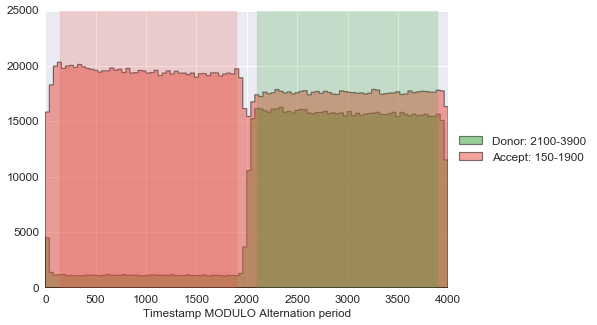

In [6]:
d.add(det_donor_accept=(0, 1), 
      alex_period=4000, 
      D_ON=(2100, 3900), 
      A_ON=(150, 1900),
      offset=700)
bpl.plot_alternation_hist (d)
loader.usalex_apply_period(d)

# Burst Search and Selection

In [7]:
d.calc_bg(bg.exp_fit, time_s=50.1, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... 

[DONE]


In [8]:
d.burst_search(m=10, computefret=False, ph_sel=Ph_sel(Dex='DAem'))
d.calc_fret(count_ph=True, corrections=False)

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for Dex ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


In [9]:
ds = d.select_bursts(select_bursts.naa, th1=30, computefret=False)
ds1 = ds.select_bursts(select_bursts.size, th1=30, computefret=False)
ds_FRET = ds1.select_bursts(select_bursts.S, S1=0.25, S2=0.85, computefret=False)

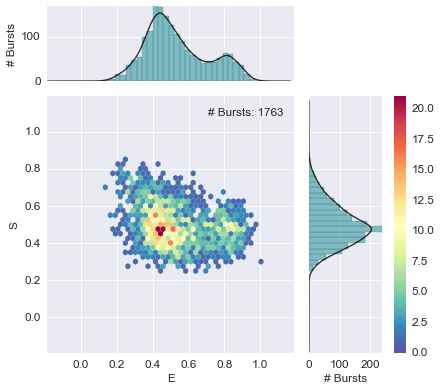

In [10]:
dx=ds_FRET
alex_jointplot(dx)

# Burst Variance Analysis

In [11]:
bursts = ds_FRET.mburst[0]
ph_d = ds_FRET.get_ph_times(ph_sel=Ph_sel(Dex='DAem'))
AemDex_mask = ds_FRET.get_ph_mask(ph_sel=Ph_sel(Dex='Aem')) 
Dex_mask = ds_FRET.get_ph_mask(ph_sel=Ph_sel(Dex='DAem'))   
AemDex_mask_d = AemDex_mask[Dex_mask]

In [12]:
bursts_d = bursts.recompute_index_reduce(ph_d)

In [13]:
n=7         # Determine the number of photons inside each sub-burst

Std_small=[]
Avg_small=[]
for burst in bursts_d:
    E_small=[]
    startlist = range(burst.istart, burst.istop + 2 - n, n)
    stoplist = [i + n for i in startlist]
    for start, stop in zip(startlist, stoplist): 
        A_D = AemDex_mask_d[start:stop].sum()
        assert stop-start == n
        E = A_D / n
        E_small.append(E)
    Std_small.append(np.std(E_small))

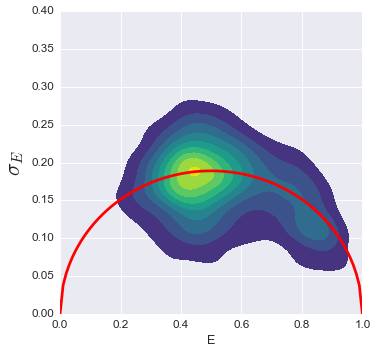

In [14]:
plt.figure(figsize=(6,6))
x = np.arange(0,1.01,0.01)
y = np.sqrt((x*(1-x))/n)
plt.plot(x,y, lw=3, color='red')
im = sns.kdeplot(ds_FRET.E_, np.array(Std_small), shade=True, cmap='viridis', shade_lowest=False)
plt.xlim(0,1)
plt.ylim(0,0.4)
plt.xlabel('E', fontsize=14)
plt.ylabel(r'$\sigma_E$', fontsize=24)